# Рекомендательные системы

Я выбрал за основу датасет с информацией от компании Steam - крупного игрового хаба, в датасете представлена информация о том, какие пользователи в какие игры играли. На основании этого будем делать предположения о том, насколько пользовтеля может заинтересовать новая игра

Датасет представлен в формате CSV со следующими столбцами:

- **user_id** - идентификатор пользователя
- **game_name** - название игры
- **behavior_name** - значение `play` или `purchase`. Если значение `play`, то пользователь играл в игру, если `purchase`, то пользователь только купил игру
- **value** - Если значение `play`, то значение - время, проведенное в игре, если `purchase`, то значение всегда равно 1.0

## Разведочный анализ 

In [1]:
INITIAL_DATASET_FILE = "dataset_initial.csv"
DATASET_FILE = "dataset.csv"

Загрузим датасет и первично ознакомимся с ним

In [2]:
import pandas as pd

df = pd.read_csv(INITIAL_DATASET_FILE, names=['user_id', 'game_title', 'behavior_name', 'value'])
df.head()

,user_id,game_title,behavior_name,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        200000 non-null  int64  
 1   game_title     200000 non-null  object 
 2   behavior_name  200000 non-null  object 
 3   value          200000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.1+ MB


---

#### Поиск пропусков и дубликатов

Проверим наличие пропусков и дубликатов

In [4]:
print("Количество пропусков:")
print(df.isnull().sum())
print("Количество дубликатов:", df.duplicated().sum())

Количество пропусков:
user_id          0
game_title       0
behavior_name    0
value            0
dtype: int64
Количество дубликатов: 707


Как видим имеется некоторое количество дубликатов, избавимся от них

In [5]:
df = df.drop_duplicates()
print("Количество дубликатов:", df.duplicated().sum())

Количество дубликатов: 0


---

Посмотрим на общее количество уникальных пользователей и игр

In [6]:
print("Уникальных пользователей:", df['user_id'].nunique())
print("Уникальных игр:", df['game_title'].nunique())
print("Уникальных типов поведения:", df['behavior_name'].nunique())

Уникальных пользователей: 12393
Уникальных игр: 5155
Уникальных типов поведения: 2


Как видим аномалий в столбце behavior_name нет и уникальных значений как и ожидалось 2, построим распределение по этому столбцу

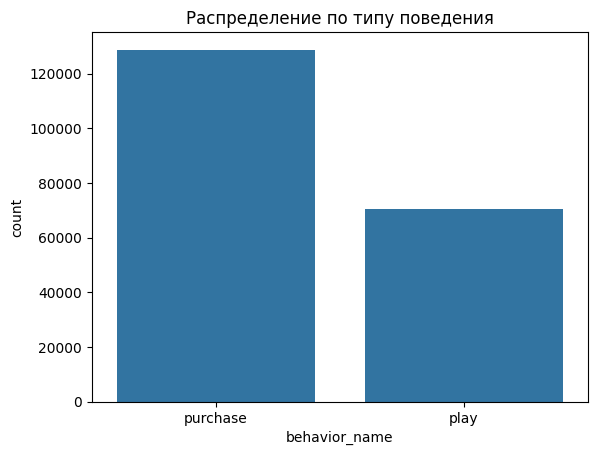

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df, x='behavior_name')
plt.title('Распределение по типу поведения')
plt.show()


#### Графики распределения

Посмотрим сколько времени люди проводят в играх

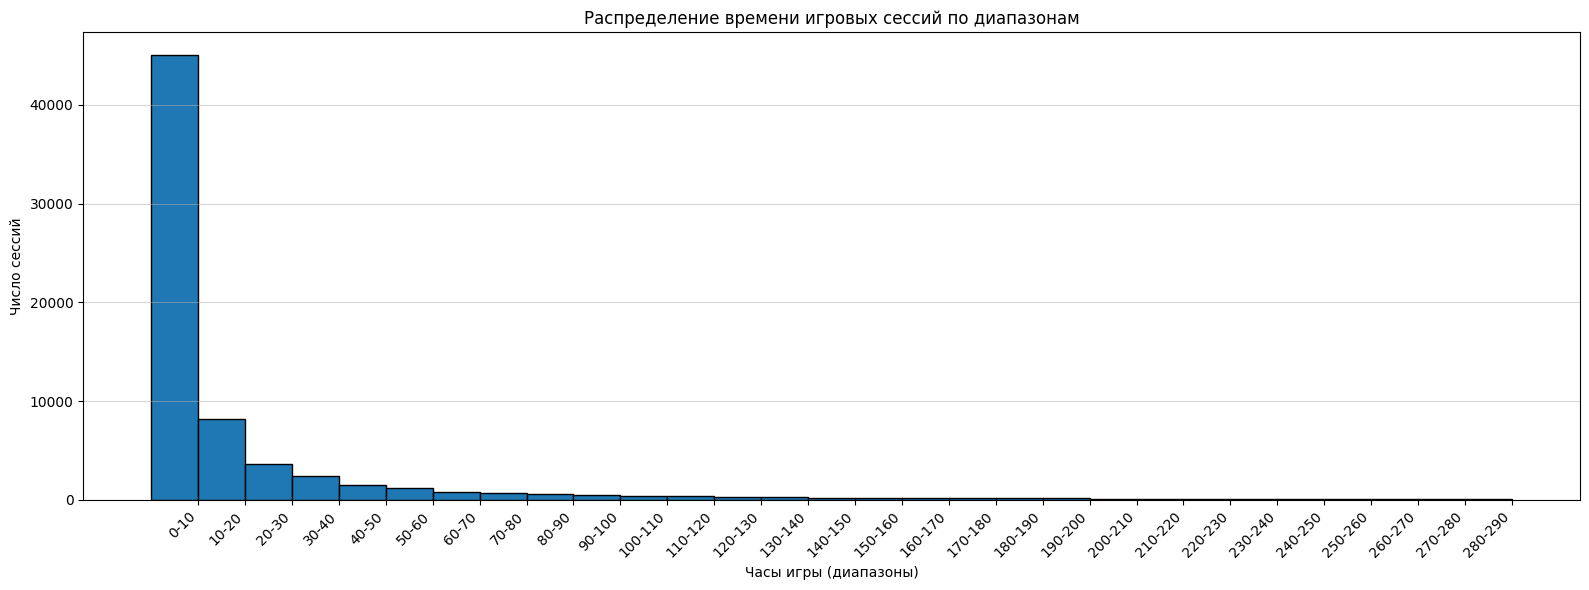

Статистика по игровым сессиям (play, value):
count    70489.000000
mean        48.878063
std        229.335236
min          0.100000
25%          1.000000
50%          4.500000
75%         19.100000
max      11754.000000
Name: value, dtype: float64


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def print_play_stats(bin_width=10):
    play_df = df[df['behavior_name'] == 'play']

    bins = np.arange(0, 300, bin_width)  # 0-10, 10-20, ..., 190-200

    fig, ax = plt.subplots(figsize=(16, 6))
    counts, bin_edges, patches = ax.hist(play_df['value'], bins=bins, edgecolor='black', width=bin_width, align='left')

    labels = [f'{int(bin_edges[i])}-{int(bin_edges[i+1])}' for i in range(len(bin_edges)-1)]
    ax.set_xticks(bin_edges[:-1] + bin_width/2)
    ax.set_xticklabels(labels, rotation=45, ha='right')

    ax.set_xlabel('Часы игры (диапазоны)')
    ax.set_ylabel('Число сессий')
    ax.set_title('Распределение времени игровых сессий по диапазонам')
    ax.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print("Статистика по игровым сессиям (play, value):")
    print(play_df['value'].describe())

print_play_stats()


Из графика видно, что в больниство игр люди играют менее 10 часов - вероятно, игра была куплена, попробована, но не понравилась

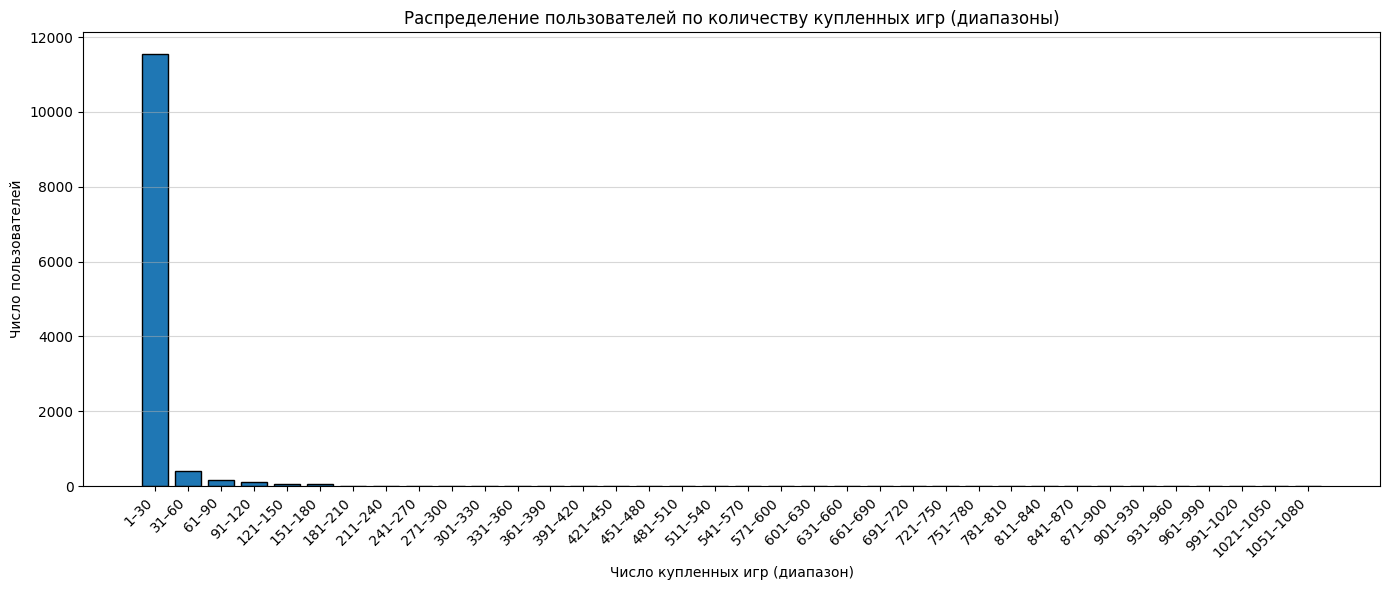

Статистика по покупкам (число купленных игр):
count    12393.000000
mean        10.393287
std         35.635890
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max       1068.000000
Name: game_title, dtype: float64


In [9]:
def print_purchase_stats(bin_width=15):
    # Датафрейм только по покупкам
    purchase_df = df[df['behavior_name'] == 'purchase']
    # Считаем, сколько игр купил каждый пользователь
    purchases_per_user = purchase_df.groupby('user_id')['game_title'].count()

    min_games = purchases_per_user.min()
    max_games = purchases_per_user.max()

    # Рассчитываем левый и правый край бин-сетки
    start = ((min_games - 1) // bin_width) * bin_width + 1
    end = ((max_games // bin_width) + 1) * bin_width + 1

    bins = np.arange(start, end, bin_width)
    if bins[-1] < max_games + 1:
        bins = np.append(bins, bins[-1] + bin_width)

    labels = [f'{bins[i]}–{bins[i + 1] - 1}' for i in range(len(bins) - 1)]

    purchases_binned = pd.cut(
        purchases_per_user, bins=bins, labels=labels, right=False, include_lowest=True
    )
    counts = purchases_binned.value_counts().sort_index()

    fig, ax = plt.subplots(figsize=(14, 6))
    bars = ax.bar(labels, counts.values, width=0.8, edgecolor='black', align='center')

    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('Число купленных игр (диапазон)')
    ax.set_ylabel('Число пользователей')
    ax.set_title('Распределение пользователей по количеству купленных игр (диапазоны)')
    ax.grid(axis='y', alpha=0.5)

    plt.tight_layout()
    plt.show()

    print("Статистика по покупкам (число купленных игр):")
    print(purchases_per_user.describe())


print_purchase_stats(bin_width=30)


Здесь видно, что большинство людей имеет относительно небольшую билиотеку - всего менее 30 игр, значит у них есть свои "любимчики" в которых они предпочитают проводить время

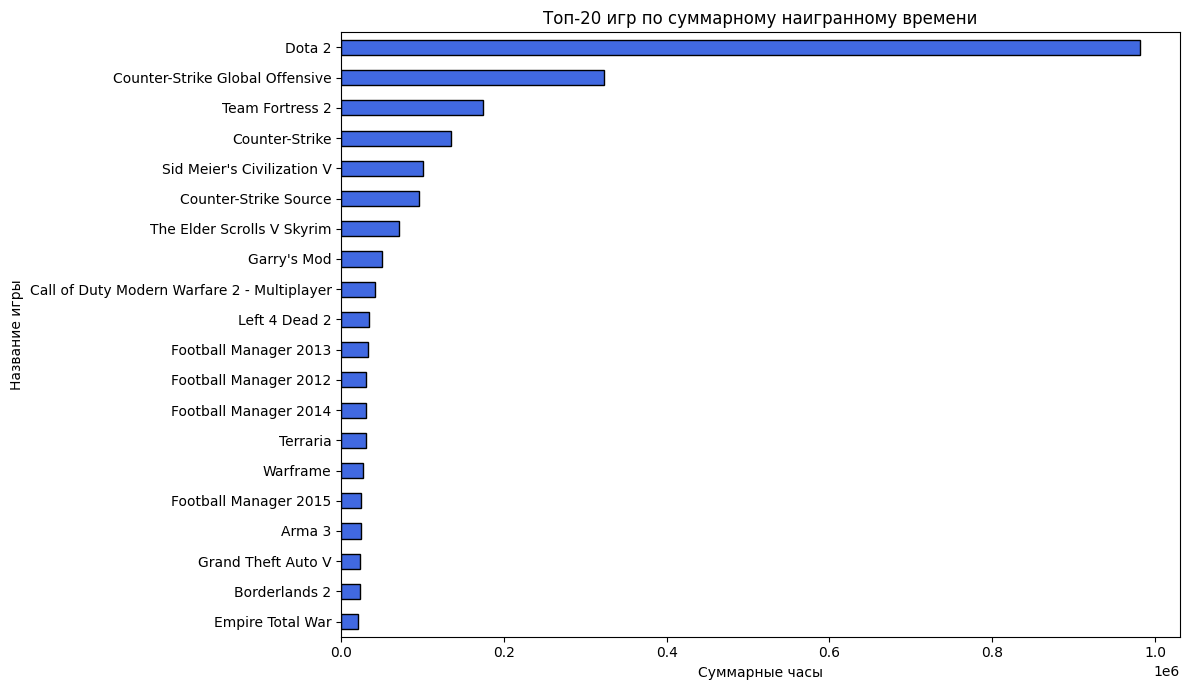

In [10]:

def print_top_games(top=20):
    play_df = df[df['behavior_name'] == 'play']
    games_time = play_df.groupby('game_title')['value'].sum().sort_values(ascending=False)

    top_games = games_time.head(top)

    plt.figure(figsize=(12, 7))
    top_games.plot(kind='barh', color='royalblue', edgecolor='black')
    plt.xlabel('Суммарные часы')
    plt.ylabel('Название игры')
    plt.title(f'Топ-{top} игр по суммарному наигранному времени')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

print_top_games()


Также видим, что есть игры, в разы превосходящие остальные по сыгранным часам

#### Выбросы

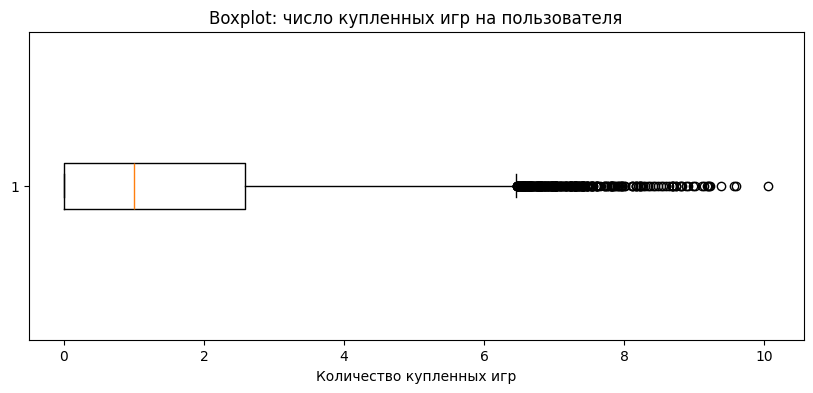

In [181]:
import matplotlib.pyplot as plt

purchase_df = df[df['behavior_name'] == 'purchase']
purchases_per_user = purchase_df.groupby('user_id')['game_title'].nunique()

plt.figure(figsize=(10, 4))
plt.boxplot(np.log2(purchases_per_user), vert=False, showfliers=True)
plt.title('Boxplot: число купленных игр на пользователя')
plt.xlabel('Количество купленных игр')
plt.show()


Видим что большинство пользователей имеет всего около 60 игр

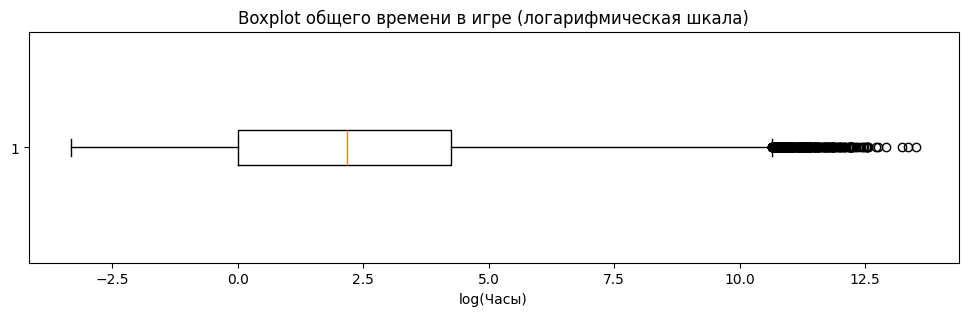

In [182]:
import numpy as np
import matplotlib.pyplot as plt

play_df = df[df['behavior_name'] == 'play']

plt.figure(figsize=(12, 3))
plt.boxplot(np.log2(play_df['value']), vert=False, showfliers=True)
plt.xlabel('log(Часы)')
plt.title('Boxplot общего времени в игре (логарифмическая шкала)')
plt.show()


Большинство людей наиграло от 0 до 1000 часов в одну игру, оставшиеся наиграли намного больше

### Выводы

Датасет довольно несбалансированный, много выбросов - есть игроки, которые играют намного больше остальных. Много игроков, которые играют только в одну игру

Тем не менее считаю то что выбросы нельзя исключать, так как они имеют массовый характер и их нельзя назвать выбросами в прямом значении, это скорее всего реальные данные и реальные люди, если их удалить, то можно потерять важную информацию о части аудитории

## Методы формирования рекомендаций

### MostPop

Метод из семейства **Non-Personalized Baselines** - простейший метод рекомендации, всем пользователям рекомендуются самые популярные игры

Не очень подходит для рекомендательной системы, может быть, только если для решения задачи "холодного старта" - когда у нас появляется новый пользователь, у которого совсем нет игр, но порекомендовать что-то нужно

In [218]:
import pandas as pd

class MostPopRecommendation:
    def __init__(self, df, criteria='purchase'):
        if criteria not in ['hours', 'purchase', 'unique_players']:
            raise ValueError("criteria must be 'hours', 'purchases' or 'unique_players'")
        self.df = df
        self.criteria = criteria
        self.popular_games = self._fit()

    def _fit(self):
        if self.criteria == 'hours':
            stats = self.df[self.df['behavior_name'] == 'play'].groupby('game_title')['value'].sum()
        elif self.criteria == 'purchase':
            stats = self.df[self.df['behavior_name'] == 'purchase'].groupby('game_title').size()
        else:
            stats = self.df[self.df['behavior_name'] == 'play'].groupby('game_title')['user_id'].nunique()

        sorted_games = stats.sort_values(ascending=False)
        return list(sorted_games.index)

    def recommend(self, user_id, N=10):
        return self.popular_games[:N]

In [219]:
mostpop_by_hours = MostPopRecommendation(df, criteria='hours')
mostpop_by_purchases = MostPopRecommendation(df, criteria='purchase')
mostpop_by_players = MostPopRecommendation(df, criteria='unique_players')

In [221]:
mostpop_by_hours.recommend(0)

['Dota 2',
 'Counter-Strike Global Offensive',
 'Team Fortress 2',
 'Counter-Strike',
 "Sid Meier's Civilization V",
 'Counter-Strike Source',
 'The Elder Scrolls V Skyrim',
 "Garry's Mod",
 'Call of Duty Modern Warfare 2 - Multiplayer',
 'Left 4 Dead 2']

In [222]:
mostpop_by_players.recommend(0)

['Dota 2',
 'Team Fortress 2',
 'Counter-Strike Global Offensive',
 'Unturned',
 'Left 4 Dead 2',
 'Counter-Strike Source',
 'The Elder Scrolls V Skyrim',
 "Garry's Mod",
 'Counter-Strike',
 "Sid Meier's Civilization V"]

In [223]:
mostpop_by_purchases.recommend(0)

['Dota 2',
 'Team Fortress 2',
 'Unturned',
 'Counter-Strike Global Offensive',
 'Half-Life 2 Lost Coast',
 'Counter-Strike Source',
 'Left 4 Dead 2',
 'Counter-Strike',
 'Warframe',
 'Half-Life 2 Deathmatch']

### UserKNN

Посмотрои алгоритм UserKNN - алгоритм ищет наиболее похожих на пользователя других игроков и рекомендует то, что есть у них но нет у текущего пользователя

Кажется что это самый рабочий алгоритм, потому что находит людей с похожими увлечениями и рекомендует пользователю то, что им понравилось, но что он не пробовал. Чисто интуитивно кажется, что он должен работать хорошо

Но, возможно, будет не очень хорошо для случаев, когда у пользователя мало игр

In [ ]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np

class UserKNNRecommendation:
    def __init__(self, df, metric='cosine', criteria='purchase'):
        if criteria == 'hours':
            play_df = df[df['behavior_name'] == 'play']
            mat = play_df.pivot_table(index='user_id', columns='game_title', values='value', fill_value=0)
        elif criteria == 'purchase':
            purchase_df = df[df['behavior_name'] == 'purchase']
            purchase_df = purchase_df.assign(val=1)
            mat = purchase_df.pivot_table(index='user_id', columns='game_title', values='value', fill_value=0)
        else:
            raise ValueError('criteria = "hours" or "purchase"')
        self.mat = mat # матрица пользователи(строки) и все игры(столбцы)
        self.user_ids = mat.index.values
        self.model = NearestNeighbors(metric=metric)
        self.model.fit(self.mat.values)

    def recommend(self, user_id, N=10):
        if user_id not in self.user_ids:
            raise ValueError('user_id is not found')

        idx = np.where(self.user_ids == user_id)[0][0]
        _, indices = self.model.kneighbors(self.mat.values[idx:idx+1])

        # 0й - сам пользователь
        neighbor_rows = indices[0][1:]
        neighbors_matrix = self.mat.iloc[neighbor_rows] # (во) что играли/купили соседи
        mean_score = neighbors_matrix.mean(axis=0) # среднее для каждой игры по соседям
        already_have = set(self.mat.loc[user_id][self.mat.loc[user_id]>0].index)
        candidates = mean_score[~mean_score.index.isin(already_have)].sort_values(ascending=False)
        return list(candidates.head(N).index)


Также напишем функцию которая ищет пользователей с интересуемым количеством игр

In [103]:
from sklearn.utils import shuffle

def get_users_with_games_in_range(min_games=2, max_games=5, top=10, behavior_name='purchase'):
    plays = df[df['behavior_name'] == behavior_name]
    user_game_counts = plays.groupby('user_id')['game_title'].nunique()
    filtered = shuffle(user_game_counts[(user_game_counts >= min_games) & (user_game_counts <= max_games)])
    print(filtered.head(top))
    return list(filtered.index)[:top]

In [ ]:
userknn = UserKNNRecommendation(df)
some_user = get_users_with_games_in_range(min_games=15, max_games=15, top=1)[0]
print(f'user_id: {some_user}')
user_games = set(df[(df['user_id'] == some_user) & (df['behavior_name'] == 'purchase')]['game_title'])
user_games

user_id
47500408    15
Name: game_title, dtype: int64
user_id: 47500408


{'Call of Duty Black Ops II',
 'Call of Duty Black Ops II - Multiplayer',
 'Call of Duty Black Ops II - Zombies',
 'Call of Duty Ghosts',
 'Call of Duty Ghosts - Multiplayer',
 'Call of Duty Modern Warfare 2',
 'Call of Duty Modern Warfare 2 - Multiplayer',
 'Call of Duty Modern Warfare 3',
 'Call of Duty Modern Warfare 3 - Multiplayer',
 'Deus Ex Human Revolution',
 'Duke Nukem Forever',
 'F.E.A.R. 2 Project Origin',
 'Half-Life 2',
 'Half-Life 2 Lost Coast',
 'Zombie Panic Source'}

In [119]:
knn_recommended = userknn.recommend(some_user)
knn_recommended

['Call of Duty Black Ops - Multiplayer',
 'Call of Duty Black Ops',
 'Day of Defeat Source',
 'Call of Duty World at War',
 'Call of Duty Advanced Warfare - Multiplayer',
 'Call of Duty Advanced Warfare',
 'Counter-Strike Source',
 'Half-Life 2 Deathmatch',
 'Dungeon Siege III',
 'Real Horror Stories Ultimate Edition']

Даже на таком простом запуске можно убедиться что алгоритм работает неплохо - как минимум правильно определено, что игроку по всему видимо нравятся шутеры серии Call of Duty, поэтому рекомендуются они + другие похожие шутеры

### EASE

Линейный рекомендательный алгоритм, каждая рекомендация строится на основе связей между играми, выявленных на всем массиве данных. Анализируя, то какие игры сейчас у пользователя в профиле, можно найти ближайшие из тех, в которые он еще не играл/покупал

In [149]:
import numpy as np
import pandas as pd

class EASERecommendation:
    def __init__(self, df, l2_reg=300., criteria='purchase'):
        if criteria not in ['purchase', 'play']:
            raise ValueError("criteria = 'hours' or 'purchase'")

        play_df = df[df['behavior_name'] == criteria]
        matrix = play_df.pivot_table(index='user_id', columns='game_title', values='value', aggfunc='sum', fill_value=0)
        mat_bin = (matrix > 0).astype(np.float32)
        self.user_ids = mat_bin.index
        self.game_titles = mat_bin.columns

        X = mat_bin.values  # users x items
        G = X.T @ X  # корелляционная матрица
        diag_indices = np.diag_indices(G.shape[0])
        G[diag_indices] += l2_reg  # регуляризация по диагонали

        P = np.linalg.inv(G) # Обратная матрица
        B = -P / np.diag(P)
        B[diag_indices] = 0.0
        self.B = B  # item-item веса
        self.X = X

    def recommend(self, user_id, N=10):
        if user_id not in self.user_ids:
            raise ValueError("user_id не найден в обучающей выборке.")
        
        user_idx = np.where(self.user_ids == user_id)[0][0]
        user_profile = self.X[user_idx]
        scores = user_profile @ self.B
        
        scores[user_profile > 0] = -1e9
        top_idx = np.argsort(scores)[-N:][::-1]
        return [self.game_titles[i] for i in top_idx]

In [159]:
ease = EASERecommendation(df)

some_user_id = get_users_with_games_in_range(min_games=15, max_games=15, top=1)[0]
print(f'user_id: {some_user_id}')
user_games = set(df[(df['user_id'] == some_user_id) & (df['behavior_name'] == 'purchase')]['game_title'])
user_games

user_id
77870593    15
Name: game_title, dtype: int64
user_id: 77870593


{'Empire Total War',
 'Medieval II Total War',
 'Medieval II Total War Kingdoms',
 'Men of War',
 'Men of War Assault Squad',
 'Men of War Condemned Heroes',
 'Men of War Red Tide',
 'Men of War Vietnam',
 'Napoleon Total War',
 'Rome Total War',
 'Rome Total War - Alexander',
 "Sid Meier's Civilization V",
 'Sniper Elite V2',
 'Toy Soldiers',
 'Wargame European Escalation'}

In [160]:
ease_recommended = ease.recommend(some_user_id)
ease_recommended

['Total War SHOGUN 2',
 'Total War ROME II - Emperor Edition',
 'Total War SHOGUN 2 - Fall of the Samurai',
 'Mount & Blade Warband',
 "Sid Meier's Civilization V Brave New World",
 'Rising Storm/Red Orchestra 2 Multiplayer',
 'Company of Heroes 2',
 "Sid Meier's Civilization V Scrambled Continents Map Pack",
 'Crusader Kings II',
 'Total War ATTILA']

Также видим, что рекомендательная система смогла различить любовь пользователя к стратегиям и порекоендовала новые

## Метрики

### Precision & Recall

In [202]:
def precision_at_k(recs, test, k=10):
    precisions = []
    for user in recs:
        recs_k = set(recs[user][:k])
        relevant = test.get(user, set())
        if not recs_k:
            continue
        precision = len(recs_k & relevant) / len(recs_k)
        precisions.append(precision)
    if not precisions:
        return 0.0
    return sum(precisions) / len(precisions)

def recall_at_k(recs, test, k=10):
    recalls = []
    for user in recs:
        recs_k = set(recs[user][:k])
        relevant = test.get(user, set())
        if not relevant:
            continue
        recall = len(recs_k & relevant) / len(relevant)
        recalls.append(recall)
    if not recalls:
        return 0.0
    return sum(recalls) / len(recalls)

### nDCG

In [203]:
import numpy as np

def ndcg_at_k(recs, test, k=10):
    ndcgs = []
    for user in recs:
        recs_k = recs[user][:k]
        relevant = test.get(user, set())
        dcg = 0.0
        for i, item in enumerate(recs_k):
            if item in relevant:
                dcg += 1 / np.log2(i + 2)
        idcg = sum(1 / np.log2(i + 2) for i in range(min(len(relevant), k)))
        if idcg == 0:
            continue
        ndcgs.append(dcg / idcg)
    if not ndcgs:
        return 0.0
    return sum(ndcgs) / len(ndcgs)


### Novelty

In [246]:
def novelty_at_k(recs, item_popularity, num_users=1000, k=10):
    novelties = []
    for user in recs:
        recs_k = recs[user][:k]
        novelty = 0
        for item in recs_k:
            pop = item_popularity.get(item, 0)
            # P(item) — популярность в долях пользователей
            p = pop / num_users if pop > 0 else 1e-9  # чтобы избежать деления на 0
            novelty += -np.log2(p)
        novelties.append(novelty / k)
    if not novelties:
        return 0.0
    return sum(novelties) / len(novelties)



### Запуск и сравнение

In [247]:
def evaluate_recommender(recommender, df, metric_func, k=10, criteria='purchase', n_users=1000, random_state=42):
    if criteria not in ['purchase', 'play']:
        raise ValueError('criteria must be "purchase" or "play"')
    
    df = df[df['behavior_name'] == criteria].copy()
    user_counts = df['user_id'].value_counts()
    valid_users = user_counts[user_counts > 1].index
    df = df[df['user_id'].isin(valid_users)].copy()

    np.random.seed(random_state)
    sampled_users = np.random.choice(valid_users, size=min(n_users, len(valid_users)), replace=False)
    df = df[df['user_id'].isin(sampled_users)]

    test_indices = df.groupby('user_id').sample(1, random_state=random_state).index
    test_df = df.loc[test_indices]
    train_df = df.drop(index=test_indices)

    test_dict = test_df.groupby('user_id')['game_title'].apply(set).to_dict()
    rec_model = recommender(train_df)
    recs_dict = {u: rec_model.recommend(u, N=k) for u in test_dict.keys()}

    score = metric_func(recs_dict, test_dict, k=k)
    return score

In [248]:
def run_all_metrics(name, recommender, df, k=10):
    precision_score = evaluate_recommender(recommender=recommender, df=df, metric_func=precision_at_k, k=k)
    recall_score = evaluate_recommender(recommender=recommender, df=df, metric_func=precision_at_k, k=k)
    ndcg_score = evaluate_recommender(recommender=recommender, df=df, metric_func=ndcg_at_k, k=k)
    novelty_score = evaluate_recommender(recommender=recommender, df=df, metric_func=novelty_at_k, k=k)
    print(f"{name} | precision: {precision_score:.4f}, recall: {recall_score:.4f}, ndcg: {ndcg_score:.4f}, novelty: {novelty_score:.4f}")

In [249]:
run_all_metrics(name='MostPop', recommender=lambda df: MostPopRecommendation(df=df), df=df)


MostPop | precision: 0.0240, recall: 0.0240, ndcg: 0.1358, novelty: 29.8974


In [250]:
run_all_metrics('UserKNN', recommender=lambda df: UserKNNRecommendation(df=df, criteria='purchase'), df=df)

UserKNN | precision: 0.0234, recall: 0.0234, ndcg: 0.1900, novelty: 29.8974


In [251]:
run_all_metrics('MostPop', recommender=lambda df: EASERecommendation(df), df=df)

MostPop | precision: 0.0475, recall: 0.0475, ndcg: 0.3683, novelty: 29.8974
